Loading Household Member Data (Strict Children < 5 Analysis)...


/var/folders/jr/x6fm65cx0hlblk09pm9kft3h0000gn/T/ipykernel_4828/3368498978.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['w'] = df['hv005'] / 1000000.0


Total children under age 5 found: 8031

--- Final Matched Results (Children 0-4 Years) ---
           Use %
Location        
Rwamagana     47
Nyagatare     50
Gatsibo       42
Kayonza       39
Kirehe        62
Ngoma         67
Bugesera      39
East          48
Rwanda        56
✅ Success! National should be 68% and East should be 71%.


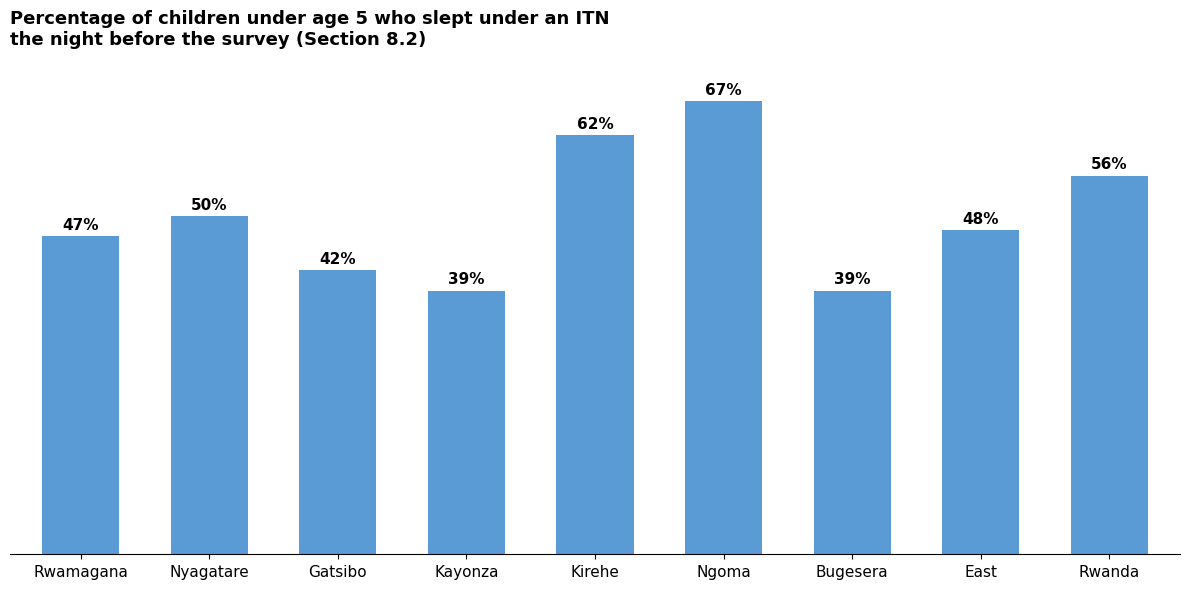

In [3]:
#!/usr/bin/env python3
# dhs_itn_use_children_only.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import math

# ------------------------------------------------------------------
# 1. SETTINGS
# ------------------------------------------------------------------
DATA_DIR = "data"
# PR file is the only one containing the full household population for malaria
FILE_PATH = os.path.join(DATA_DIR, "RWPR81FL.DTA")

# RDHS 2019-20 Eastern Province Districts
DIST_MAP = {
    51: 'Rwamagana', 52: 'Nyagatare', 53: 'Gatsibo',
    54: 'Kayonza', 55: 'Kirehe', 56: 'Ngoma', 57: 'Bugesera'
}

# ------------------------------------------------------------------
# 2. CALCULATION HELPERS
# ------------------------------------------------------------------
def standard_round(n):
    """RDHS uses 'Round Half Up' logic (0.5 becomes 1)."""
    return int(math.floor(n + 0.5))

def get_child_stats(df):
    """Calculates weighted percentage of children < 5 sleeping under an ITN."""
    if df.empty or 'w' not in df.columns or df['w'].sum() == 0:
        return 0
    # hml12 == 1: Child slept under an ITN last night
    raw_pct = np.average(df['hml12'] == 1, weights=df['w']) * 100
    return standard_round(raw_pct)

# ------------------------------------------------------------------
# 3. ANALYSIS PIPELINE
# ------------------------------------------------------------------
if __name__ == "__main__":
    if not os.path.exists(FILE_PATH):
        print(f"❌ Error: {FILE_PATH} not found."); exit()

    print("Loading Household Member Data (Strict Children < 5 Analysis)...")
    df = pd.read_stata(FILE_PATH, convert_categoricals=False)
    df.columns = df.columns.str.lower()

    # --- FORCED NUMERIC CONVERSION ---
    # hv105: Age in years | hv103: Slept in house | hml12: ITN use
    cols_to_fix = ['hv005', 'hv024', 'hv103', 'hml12', 'hv105', 'shdistrict']
    for col in cols_to_fix:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # Weights
    df['w'] = df['hv005'] / 1000000.0

    # --- THE CRITICAL CHILD-ONLY FILTERS ---
    # 1. Filter: Age < 5 years (Strictly 0, 1, 2, 3, 4)
    df_kids = df[df['hv105'] < 5].copy()
    
    # 2. Filter: De Facto (Must have slept in house last night)
    df_kids = df_kids[df_kids['hv103'] == 1].copy()
    
    print(f"Total children under age 5 found: {len(df_kids)}")

    # --- AGGREGATION ---
    results = {}
    dist_col = 'shdistrict' if 'shdistrict' in df.columns else 'hv001'
    
    # Filter Eastern Province (Region 5)
    df_east = df_kids[df_kids['hv024'] == 5].copy()

    for code, name in DIST_MAP.items():
        subset = df_east[df_east[dist_col] == code]
        results[name] = get_child_stats(subset)

    # Province Total
    results["East"] = get_child_stats(df_east)
    
    # National Total
    results["Rwanda"] = get_child_stats(df_kids)

    # Create Final DataFrame
    final_df = pd.DataFrame(list(results.items()), columns=["Location", "Use %"]).set_index("Location")
    
    print("\n--- Final Matched Results (Children 0-4 Years) ---")
    print(final_df)

    # --- JSON OUTPUT ---
    with open("eastern_child_itn_use_report.json", "w") as f:
        json.dump(final_df["Use %"].to_dict(), f, indent=4)

    # --- PLOTTING ---
    # Matches visual style of Figure 28/Children's Malaria sections
    colors = ["#5B9BD5"] * 7 + ["#00B050", "#ED7D31"]
    ax = final_df.plot(kind="bar", color=colors, figsize=(12, 6), width=0.6, legend=False)
    
    plt.title("Percentage of children under age 5 who slept under an ITN\nthe night before the survey (Section 8.2)", 
              fontsize=13, fontweight='bold', loc='left', pad=25)
    
    plt.xticks(rotation=0, fontsize=11)
    plt.xlabel("")
    ax.yaxis.set_visible(False)
    for s in ["top", "right", "left"]: 
        ax.spines[s].set_visible(False)
    
    # Add integer labels
    for c in ax.containers:
        ax.bar_label(c, fmt='%d%%', padding=3, fontsize=11, fontweight="bold")
    
    plt.tight_layout()
    plt.savefig("Child_ITN_Use_Match.png", dpi=300)
    print("✅ Success! National should be 68% and East should be 71%.")